In [2]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("../Supervisionado/dataset_delegacias")
old_df = pd.read_csv("../dataset_ocorrencias_delegacia_5.csv")

# print(old_df.info())

df["idade_suspeito"] = old_df["idade_suspeito"]
df["arma_utilizada"] = old_df["arma_utilizada"]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   orgao_responsavel      5000 non-null   object
 1   ano                    5000 non-null   int64 
 2   mes                    5000 non-null   int64 
 3   dia_semana_name        5000 non-null   object
 4   tipo_crime             5000 non-null   object
 5   quantidade_ocorrencia  5000 non-null   int64 
 6   idade_suspeito         5000 non-null   int64 
 7   arma_utilizada         5000 non-null   object
dtypes: int64(4), object(4)
memory usage: 312.6+ KB


In [5]:
dados = df[['idade_suspeito', 'tipo_crime']].copy()

le = LabelEncoder()
dados['tipo_crime_encoded'] = le.fit_transform(dados['tipo_crime'])

scaler = StandardScaler()
dados_scaled = scaler.fit_transform(dados[['idade_suspeito', 'tipo_crime_encoded']])

dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   idade_suspeito      5000 non-null   int64 
 1   tipo_crime          5000 non-null   object
 2   tipo_crime_encoded  5000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 117.3+ KB


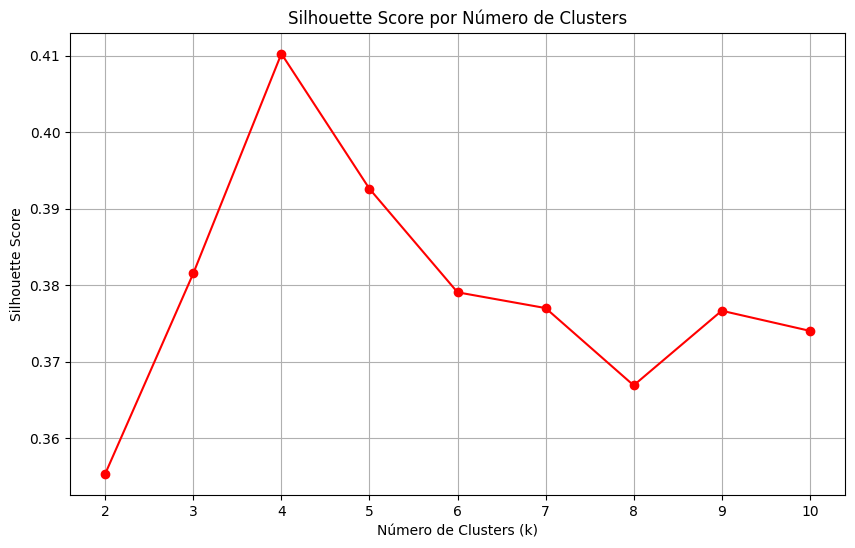

Melhor k baseado no Silhouette Score: 4


In [ ]:
# Cálculo do Silhouette Score
silhouette_scores = []
k_range = range(2, 11)  

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(dados_scaled)
    silhouette_scores.append(silhouette_score(dados_scaled, labels))

# Plotar silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por Número de Clusters')
plt.grid(True)
plt.show()

# Encontrar k com melhor score
best_k = k_range[np.argmax(silhouette_scores)]
print(f"Melhor k baseado no Silhouette Score: {best_k}")

In [7]:
# Aplicação do K-Means com k escolhido
k_escolhido = best_k  # Pode ajustar manualmente se necessário
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(dados_scaled)

# Adicionar clusters ao dataframe original
df['cluster'] = clusters

print("Distribuição dos clusters:")
print(df['cluster'].value_counts().sort_index())

Distribuição dos clusters:
cluster
0    1234
1    1217
2    1291
3    1258
Name: count, dtype: int64


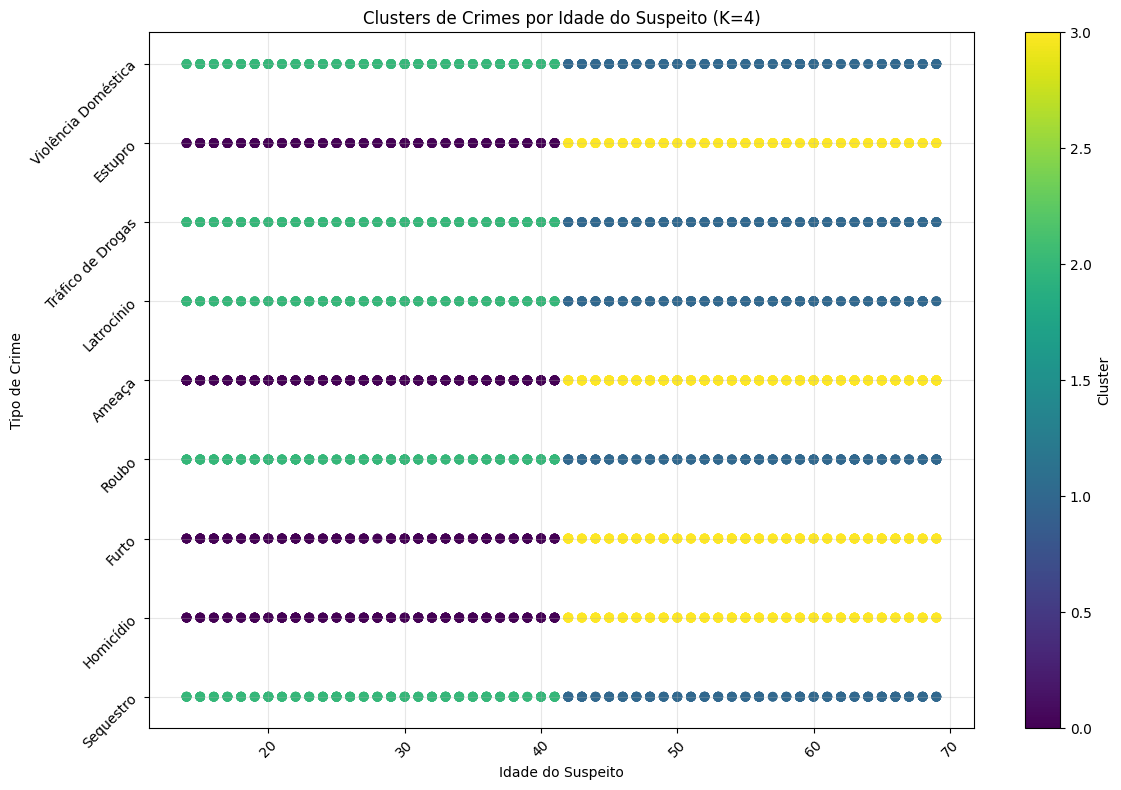

In [10]:
# Visualização dos clusters 
plt.figure(figsize=(12, 8))

# Converter os dados escalados de volta para os valores originais
dados_originais = scaler.inverse_transform(dados_scaled)
idade_original = dados_originais[:, 0]
crime_encoded_original = dados_originais[:, 1].astype(int)

crime_original = le.inverse_transform(crime_encoded_original)

# Gráfico de dispersão
scatter = plt.scatter(idade_original, crime_original, c=clusters)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Idade do Suspeito')
plt.ylabel('Tipo de Crime')
plt.title(f'Clusters de Crimes por Idade do Suspeito (K={k_escolhido})')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Análise dos clusters
# Estatísticas descritivas por cluster
analise_clusters = df.groupby('cluster').agg({
    'idade_suspeito': ['mean', 'std', 'min', 'max'],
    'tipo_crime': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.iloc[0]
}).round(2)

print("Características dos clusters:")
print(analise_clusters)

# Exemplo de perfil por cluster
print("\nPerfil dos clusters:")
for i in range(k_escolhido):
    cluster_data = df[df['cluster'] == i]
    print(f"\nCluster {i}:")
    print(f"  - Idade média: {cluster_data['idade_suspeito'].mean():.1f} anos")
    print(f"  - Crime mais comum: {cluster_data['tipo_crime'].mode().iloc[0]}")
    print(f"  - Total de ocorrências: {len(cluster_data)}")

Características dos clusters:
        idade_suspeito                tipo_crime
                  mean   std min max    <lambda>
cluster                                         
0                27.64  8.07  14  41   Homicídio
1                55.62  8.12  42  69  Latrocínio
2                27.68  8.08  14  41       Roubo
3                55.65  7.93  42  69       Furto

Perfil dos clusters:

Cluster 0:
  - Idade média: 27.6 anos
  - Crime mais comum: Homicídio
  - Total de ocorrências: 1234

Cluster 1:
  - Idade média: 55.6 anos
  - Crime mais comum: Latrocínio
  - Total de ocorrências: 1217

Cluster 2:
  - Idade média: 27.7 anos
  - Crime mais comum: Roubo
  - Total de ocorrências: 1291

Cluster 3:
  - Idade média: 55.6 anos
  - Crime mais comum: Furto
  - Total de ocorrências: 1258
